# Vehicle Detection

First, I'll load all the images from the train set

In [1]:
import matplotlib.image as mpimg
import numpy as np

import cv2
import glob

def load_images(category):
    filenames = glob.glob('train/'+category+'/**/*.png', recursive=True)
    
    images = []
    for f in filenames:
        img = mpimg.imread(f)
        images.append(img)

    return images
        
vehicles = load_images('vehicles')
non_vehicles = load_images('non-vehicles')

Then, I'll Perform a Histogram of Oriented Gradients (HOG) feature extraction on those images

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell), 
        cells_per_block=(cell_per_block, cell_per_block), 
        visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell), 
        cells_per_block=(cell_per_block, cell_per_block), 
        visualise=vis, feature_vector=feature_vec)
        
        return features

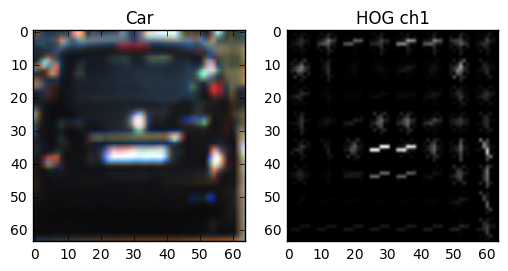

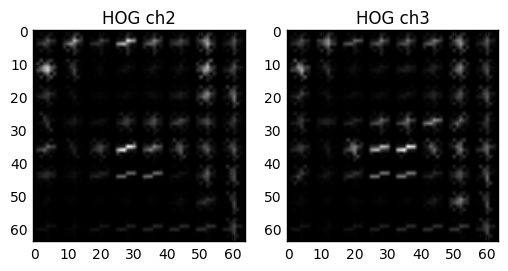

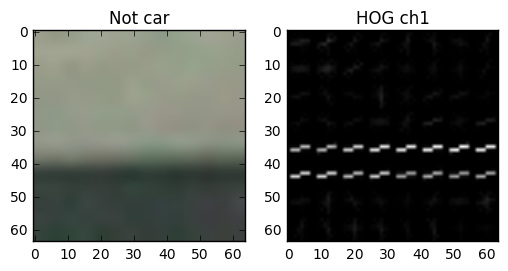

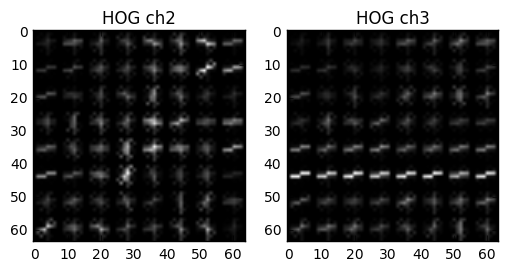

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

def graph(im, title):
    new_img = cv2.cvtColor(im, cv2.COLOR_RGB2YCR_CB)
    ch1 = new_img[:,:,0]
    ch2 = new_img[:,:,1]
    ch3 = new_img[:,:,2]

    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(ch1, orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            vis=True, feature_vec=False)
    features2, hog_image2 = get_hog_features(ch2, orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            vis=True, feature_vec=False)
    features3, hog_image3 = get_hog_features(ch3, orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            vis=True, feature_vec=False)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(im)
    plt.title(title)
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG ch1')
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(hog_image2, cmap='gray')
    plt.title('HOG ch2')
    plt.subplot(122)
    plt.imshow(hog_image3, cmap='gray')
    plt.title('HOG ch3')
idx_veh = np.random.randint(len(vehicles))
idx_not = np.random.randint(len(non_vehicles))
graph(vehicles[idx_veh], 'Car')
graph(non_vehicles[idx_not], 'Not car')

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

spatial_size=(32, 32)
hist_bins= 32
hist_range=(0, 256)

def get_images_features(images, feature_vec=True):
    ret = []
    d = {}
    count = 0
    for im in images:
        im_ycr = cv2.cvtColor(im, cv2.COLOR_RGB2YCR_CB)
        
        bin_features = bin_spatial(im_ycr, spatial_size)
        color_hist_features = color_hist(im_ycr, nbins=hist_bins, bins_range=hist_range)
        
        ch1 = im_ycr[:,:,0]
        ch2 = im_ycr[:,:,1]
        ch3 = im_ycr[:,:,2]
        
        hog_features1 = get_hog_features(ch1, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, vis=False, feature_vec=feature_vec)
        hog_features2 = get_hog_features(ch2, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, vis=False, feature_vec=feature_vec)
        hog_features3 = get_hog_features(ch3, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, vis=False, feature_vec=feature_vec)

        features = np.hstack((hog_features1, hog_features2, hog_features3, bin_features, color_hist_features))

        ret.append(features)

#         hsh = hash(str(features))
#         if (not hsh in d): #skip repeated images
#             d[hsh] = im
#             ret.append(features)
#         else:
#             count += 1
#     print("skipped %d images" % count)
    return ret

In [6]:
car_features = get_images_features(vehicles)
notcar_features = get_images_features(non_vehicles)

Next, I will build the labels vector and split the data

In [7]:
import numpy as np
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

Train/test the model

In [8]:
from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
print('Training the model on %d images' % len(X_train))
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = %f on %d images' % (svc.score(X_test, y_test), len(X_test)))

Training the model on 14208 images
Test Accuracy of SVC = 0.992680 on 3552 images


Apply sliding window techniques to the images

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
        
    if y_start_stop == [None, None]:
        y_start_stop = [0, img.shape[0]]

    # Compute the span of the region to be searched
    spanx = x_start_stop[1] - x_start_stop[0]
    spany = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    stepx = int(xy_window[0]*xy_overlap[0])
    stepy = int(xy_window[1]*xy_overlap[1])
    
    # Compute the number of windows in x/y
    nx = int((spanx-stepx)/stepx)
    ny = int((spany-stepy)/stepy)

    # Initialize a list to append window positions to
    window_list = []
    for i in range(ny):
        for j in range(nx):
            x = x_start_stop[0] + j*stepx
            y = y_start_stop[0] + i*stepy
            window_list.append( ((x, y), (x+xy_window[0], y+xy_window[1])) )

    return window_list

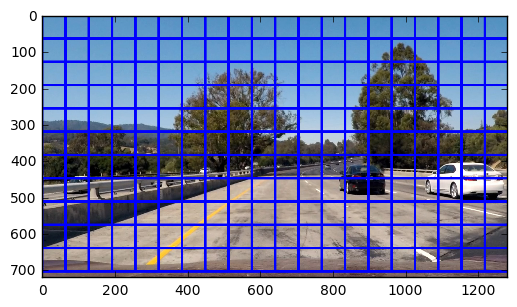

In [10]:
test_image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                   
window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Apply sliding window to the images

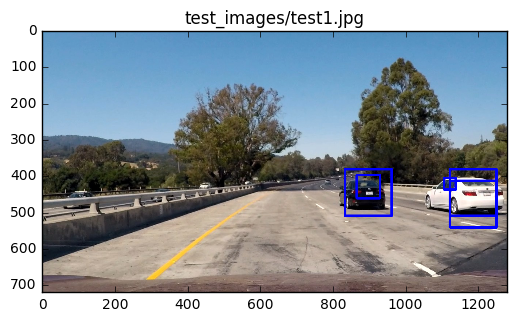

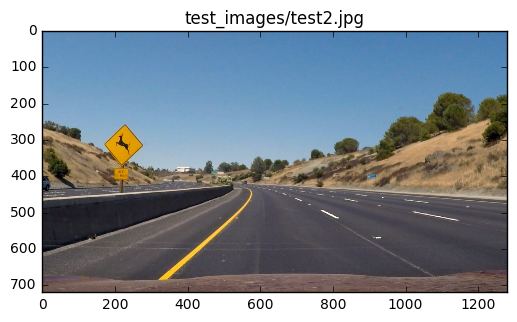

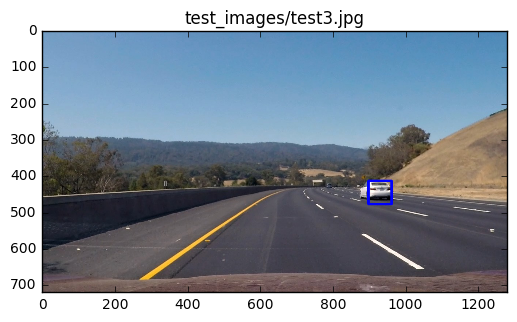

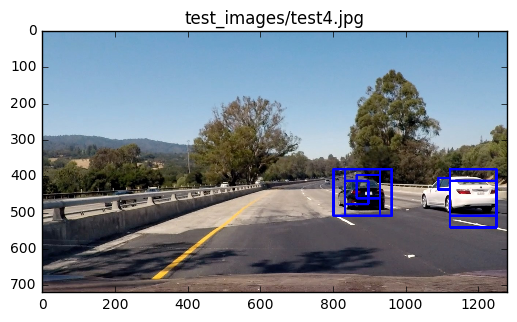

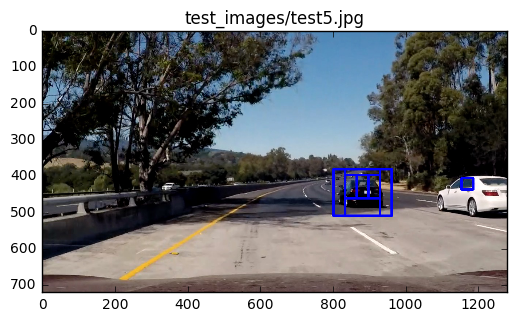

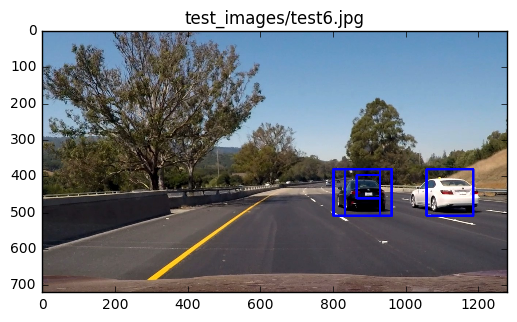

In [11]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

def detect(img, scale, ystart, yend):
    new_img = np.copy(img)
    orig_img = np.copy(new_img)
    
    if (new_img.shape[1] < ystart):
        ystart = 0
        
    yend = min(yend, new_img.shape[0])

    img2search = new_img[ystart:yend,:]
    (height, width, _) = img2search.shape

    if (scale != 1):
        img2search = cv2.resize(img2search,(np.int(width/scale), np.int(height/scale)), interpolation = cv2.INTER_CUBIC)

    im_ycrcb = cv2.cvtColor(img2search, cv2.COLOR_RGB2YCR_CB)
    im_ycrcb = im_ycrcb/255.
    
    ch1 = im_ycrcb[:,:,0]
    ch2 = im_ycrcb[:,:,1]
    ch3 = im_ycrcb[:,:,2]

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    nxblocks = (img2search.shape[1] // pix_per_cell) - 1
    nyblocks = (img2search.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks-nblocks_per_window)//cells_per_step
    nysteps = (nyblocks-nblocks_per_window)//cells_per_step
    #print("number of windows %d\n" % (nxsteps*nysteps))
    bboxes = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            x0 = np.int(xleft*scale)
            y0 = np.int(ytop*scale)

            win = np.int(window*scale)
           
            sub_img = cv2.resize(im_ycrcb[ytop:ytop+window, xleft:xleft+window], (64,64))
            bin_features = bin_spatial(sub_img, spatial_size)
            color_hist_features = color_hist(sub_img, nbins=hist_bins, bins_range=hist_range)
            
            hog_feat = np.hstack((hog_feat1, hog_feat2, hog_feat3, bin_features, color_hist_features))
    
            # Apply the scaler to X
            scaled = X_scaler.transform(hog_feat)
            is_car = svc.predict(scaled)[0]

            if (is_car):
                bboxes.append(((x0, y0+ystart), (x0+win, y0+ystart+win)))
    return bboxes
 

def detect_boxes(im):
    bboxes = []
    for scale in [0.5,1,2]:
        ystart = 350; yend = 650
        if scale < 1:
            yend = 450
            
        b = detect(im, scale, ystart = ystart, yend = yend)
        bboxes.extend(b)
    return bboxes
    
def detect_file(filename):
    im = mpimg.imread(filename)
    boxes = detect_boxes(im)
    box_img = draw_boxes(im, boxes, color=(0, 0, 255), thick=6)
    plt.figure()
    plt.imshow(box_img)
    plt.title(filename)
    return (im, boxes)
    
test_images = glob.glob('test_images/*.jpg')

bboxes = []
imgs = []
for t in test_images:
    (im, boxes) = detect_file(t)
    imgs.append(im)
    bboxes.append(boxes)

Now, let's calculate the heat map

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], 0] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

2 cars found


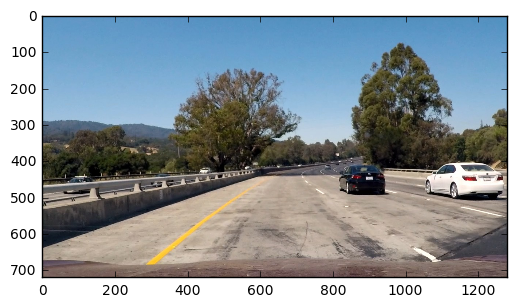

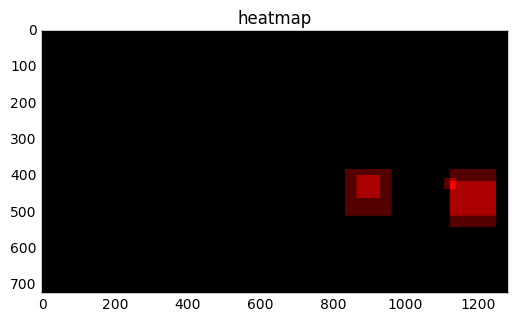

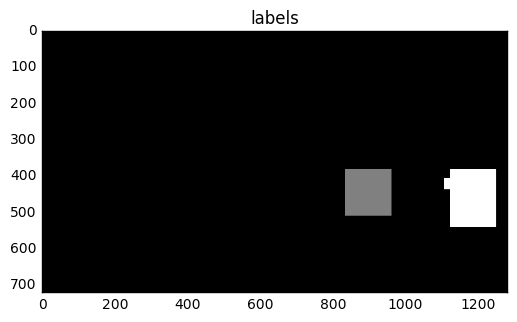

In [13]:
from scipy.ndimage.measurements import label

def build_heatmap(im, boxes):
    heatmap = np.zeros(im.shape)
    heatmap = add_heat(heatmap, boxes)
    #heatmap = apply_threshold(heatmap, 15)
    return heatmap
  
idx = 0
heatmap = build_heatmap(imgs[idx], bboxes[idx])
plt.imshow(imgs[idx])
plt.figure()

labels = label(heatmap[:,:,0])

mx = np.max(heatmap)
h = (heatmap*1./mx)

plt.imshow(h)
plt.title('heatmap')
plt.figure()

print(labels[1], 'cars found')
plt.title('labels')
plt.imshow(labels[0], cmap='gray')

Now I will draw the surrounding boxes around the cars

In [20]:
def draw_labeled_bboxes(img, labels):
    im = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(im, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return im

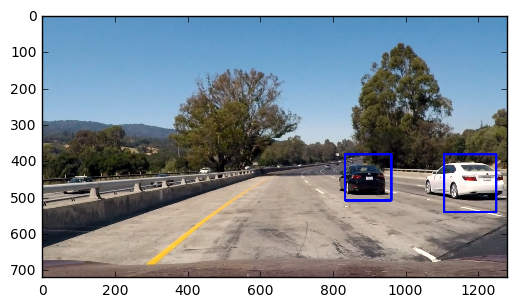

In [21]:
draw_img = draw_labeled_bboxes(imgs[idx], labels)
# Display the image
plt.imshow(draw_img)

Let's run the same over the video

In [24]:
from moviepy.editor import VideoFileClip

prev_heatmaps = []
def process_image(img):
    global prev_heatmaps

    bboxes = detect_boxes(img)    
    heatmap = build_heatmap(img, bboxes)
    
    hm = heatmap[:,:,0]

    prev_heatmaps.append(hm)
    prev_heatmaps = prev_heatmaps[-5:]

    mean_map = np.mean(np.array(prev_heatmaps), axis=0)    
    labels = label(mean_map)
    
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img

def process_video(base):
    video_filename = base + '.mp4'
    output = base + '.out.mp4'
    clip1 = VideoFileClip(video_filename)
    out_clip = clip1.fl_image(process_image)
    %time out_clip.write_videofile(output, audio=False)

#process_video('test_video')
#process_video('project_video')

[MoviePy] >>>> Building video project_video.out.mp4
[MoviePy] Writing video project_video.out.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:02<58:43,  2.80s/it]


  0%|          | 2/1261 [00:05<58:51,  2.81s/it]


  0%|          | 3/1261 [00:08<59:55,  2.86s/it]


  0%|          | 4/1261 [00:11<1:02:13,  2.97s/it]


  0%|          | 5/1261 [00:14<1:01:34,  2.94s/it]


  0%|          | 6/1261 [00:17<1:02:54,  3.01s/it]


  1%|          | 7/1261 [00:20<1:01:58,  2.96s/it]


  1%|          | 8/1261 [00:23<1:02:32,  2.99s/it]


  1%|          | 9/1261 [00:26<1:01:08,  2.93s/it]


  1%|          | 10/1261 [00:29<1:00:28,  2.90s/it]


  1%|          | 11/1261 [00:32<1:00:19,  2.90s/it]


  1%|          | 12/1261 [00:35<59:44,  2.87s/it]  


  1%|          | 13/1261 [00:37<59:14,  2.85s/it]


  1%|          | 14/1261 [00:40<58:59,  2.84s/it]


  1%|          | 15/1261 [00:43<59:03,  2.84s/it]


  1%|▏         | 16/1261 [00:46<58:50,  2.84s/it]


  1%|▏         | 17/1261 [00:49<58:41,  2.83s/it]


  1%|▏         | 18/1261 [00:52<58:36,  2.83s/it]


  2%|▏   

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.out.mp4 

CPU times: user 1h 54min 39s, sys: 3min 30s, total: 1h 58min 10s
Wall time: 1h 7min 41s
